In [ ]:
!pip install keras-unet

In [ ]:
filenames = ["0005d01c8.jpg", "00140e597.jpg","00113a75c.jpg","001dd855d.jpg","00269a792.jpg","001f3caca.jpg","0041d7084.jpg","002943412.jpg","002abd5df.jpg","002e85393.jpg"]
csv_dir = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"
source_dir = "/kaggle/input/airbus-ship-detection/train_v2"
segmented_images_dir = "/kaggle/working/segmented_images"
aug_out_dir = "/kaggle/working/output/augmented_out_images"
seg_out_dir = "/kaggle/working/output/segmented_out_images"

import os

df = pd.read_csv(csv_dir, index_col=0).dropna()

def rle_to_pixels(rle_code, shape):
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position // shape[1], pixel_position % shape[1]) 
                 for start, length in zip(rle_code[0:-1:2], rle_code[1::2]) 
                 for pixel_position in range(start, start + length)]
    return pixels

df = df.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()

def load_img(filename):
    return np.array(Image.open(f"{source_dir}/{filename}"))

def apply_colored_masks(image, masks, colors, background_color=[0, 0, 0]):
    colored_image = np.full_like(image, background_color)
    for mask, color in zip(masks, colors):
        for y, x in mask:
            colored_image[x, y, :] = color
    return colored_image

def random_color():
    return [random.randint(0, 255) for _ in range(3)]


def find_connected_components(mask, shape):
    labeled_mask = np.zeros(shape, dtype=int)
    label = 1
    components = []
    height, width = shape
    for y in range(height):
        for x in range(width):
            if mask[y, x] == 1 and labeled_mask[y, x] == 0:
                component = []
                stack = [(y, x)]
                while stack:
                    cy, cx = stack.pop()
                    if labeled_mask[cy, cx] == 0:
                        labeled_mask[cy, cx] = label
                        component.append((cy, cx))
                        for dy, dx in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                            ny, nx = cy + dy, cx + dx
                            if 0 <= ny < height and 0 <= nx < width and mask[ny, nx] == 1 and labeled_mask[ny, nx] == 0:
                                stack.append((ny, nx))
                components.append(component)
                label += 1
    return components

def convert_and_save_instance_segmentation(image_id, rle_codes, output_folder='segmented_images', background_color=[0, 0, 0]):
    os.makedirs(output_folder, exist_ok=True)
    img = np.array(Image.open(f"/kaggle/input/airbus-ship-detection/train_v2/{image_id}"))
    shape = img.shape[:2]  # (height, width)
    masks = [rle_to_pixels(rle_code, shape) for rle_code in rle_codes.split('  ') if rle_code.strip()]
    
    all_components = []
    for mask in masks:
        binary_mask = np.zeros(shape, dtype=int)
        for y, x in mask:
            binary_mask[y, x] = 1
        components = find_connected_components(binary_mask, shape)
        all_components.extend(components)
    
    colors = [random_color() for _ in range(len(all_components))]
    colored_img = apply_colored_masks(img, all_components, colors, background_color)
    result_img = Image.fromarray(colored_img)
    output_path = os.path.join(output_folder, os.path.basename(image_id))  
    result_img.save(output_path)
    
def display_image(image_path):
    img = Image.open(image_path)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
for file in filenames:
    convert_and_save_instance_segmentation(file,df.loc[df["ImageId"] == file , 'EncodedPixels'])

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

source_dir = "/kaggle/input/airbus-ship-detection/train_v2"
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv").dropna()
df = df.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()

def load_img(image_id):
    image = np.array(Image.open(image_id))
    return image

def rle_to_pixels(rle_code, shape):
    if pd.isna(rle_code):  # Handle empty masks (NaN values)
        return []

    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position // shape[1], pixel_position % shape[1]) 
              for start, length in zip(rle_code[0:-1:2], rle_code[1::2]) 
              for pixel_position in range(start, start + length)]
    return pixels

def create_binary_mask_image(image_id):
    image = load_img(image_id)
    height, width, _ = image.shape
    binary_mask = np.zeros((height, width), dtype=np.uint8)

    # Extract RLE encoding from DataFrame
    rle_encodings = df.loc[df['ImageId'] == image_id, 'EncodedPixels'].values
    for rle in rle_encodings:
        pixels = rle_to_pixels(rle, (height, width))
        for y, x in pixels:
            binary_mask[y, x] = 1

    return image, binary_mask

filenames = ["0005d01c8.jpg", "00140e597.jpg","00113a75c.jpg","001dd855d.jpg","00269a792.jpg","001f3caca.jpg","0041d7084.jpg","002943412.jpg","002abd5df.jpg","002e85393.jpg"]

for pred_mask, target_mask in [create_binary_mask_image(f"/kaggle/input/airbus-ship-detection/train_v2/{file}") for file in filenames]:
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(target_mask, cmap='gray')
        plt.title('Target Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()



In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from keras import models, layers
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet.models import satellite_unet as unetModel
from skimage.morphology import label
import gc 
import cv2
from keras_unet.utils import plot_segm_history
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

In [ ]:
### path initialisation
trainImagesPath = "/kaggle/input/airbus-ship-detection/train_v2/"
testImagesPath = "/kaggle/input/airbus-ship-detection/test_v2/"

In [ ]:
## run length encoding-decoding and mask image generation

def decodeRle(rleMask):
    rleMask = rleMask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rleMask[0:][::2], rleMask[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(768*768, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(768,768).T


def generateMaskImage(masksList):
    maskImage = np.zeros(shape=(768,768))
    for mask in masksList:
        decodedMask = decodeRle(mask)
        maskImage+=decodedMask
    return maskImage

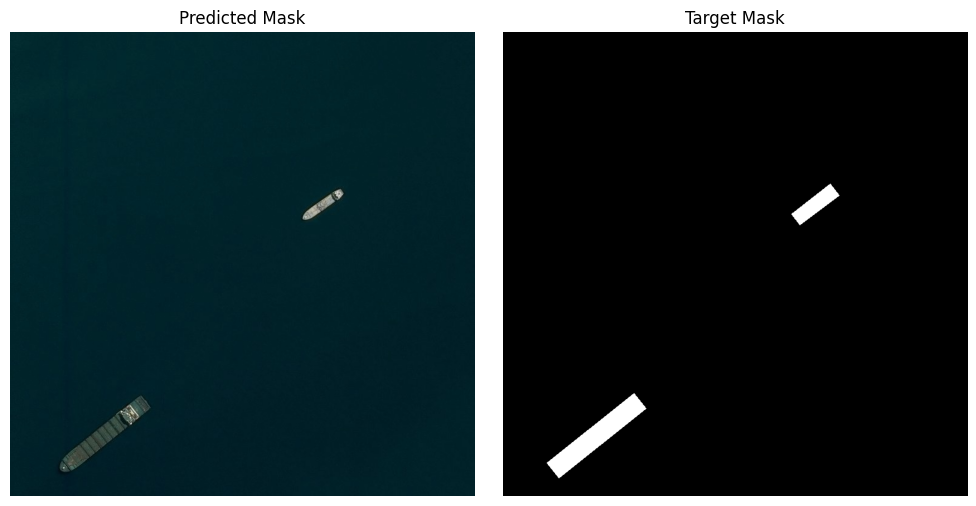

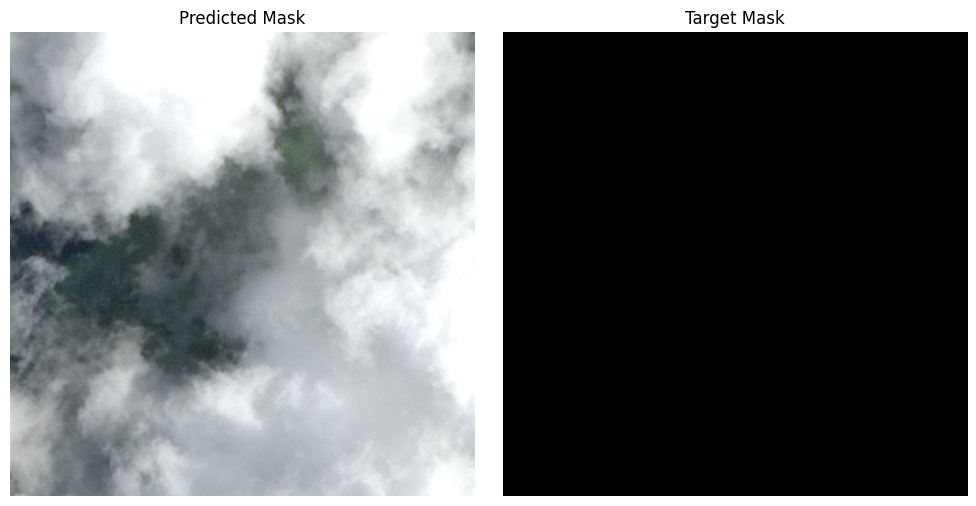

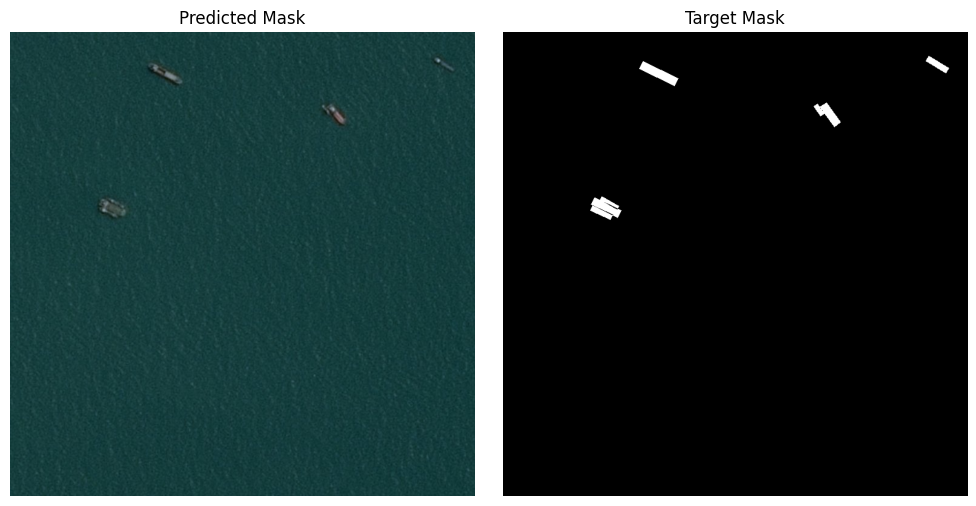

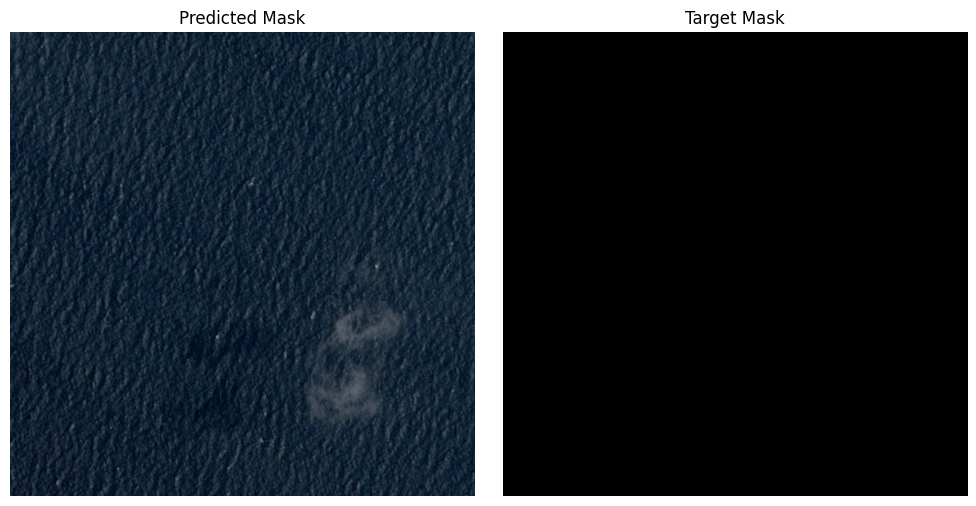

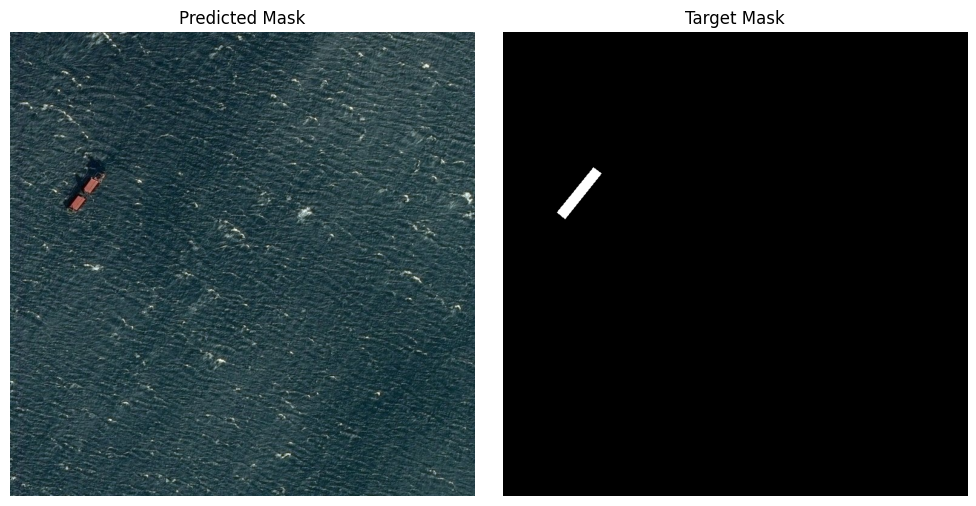

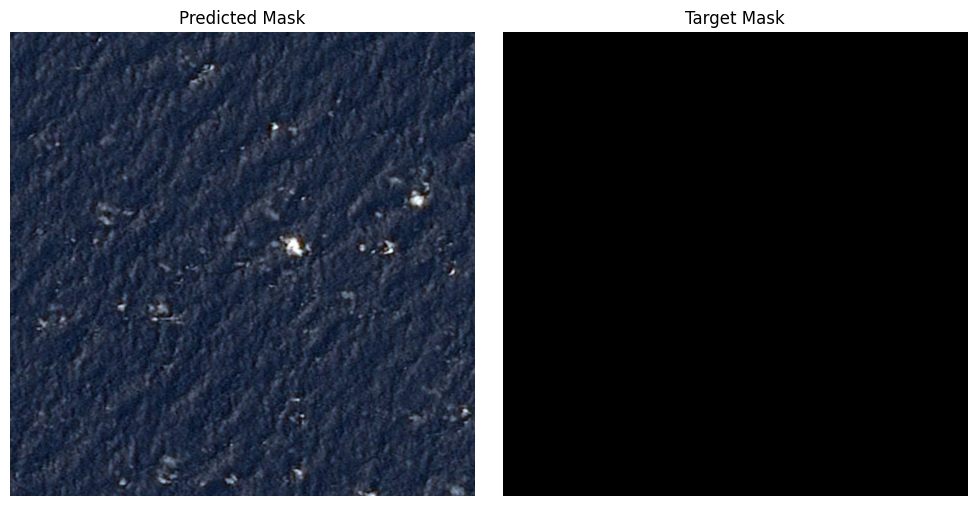

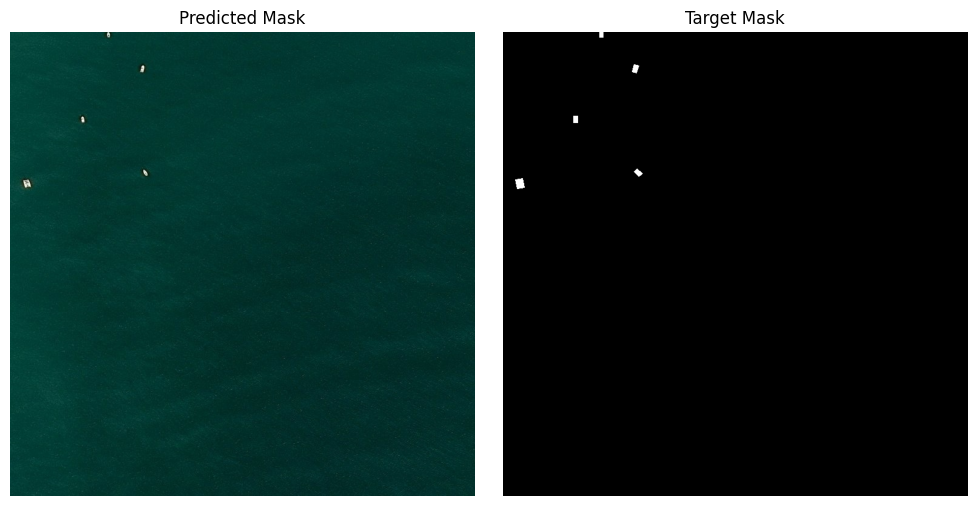

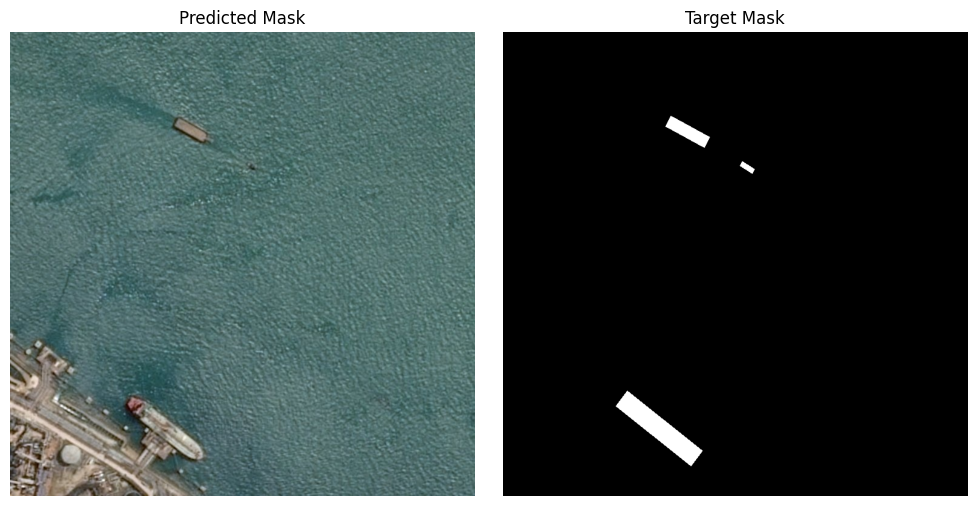

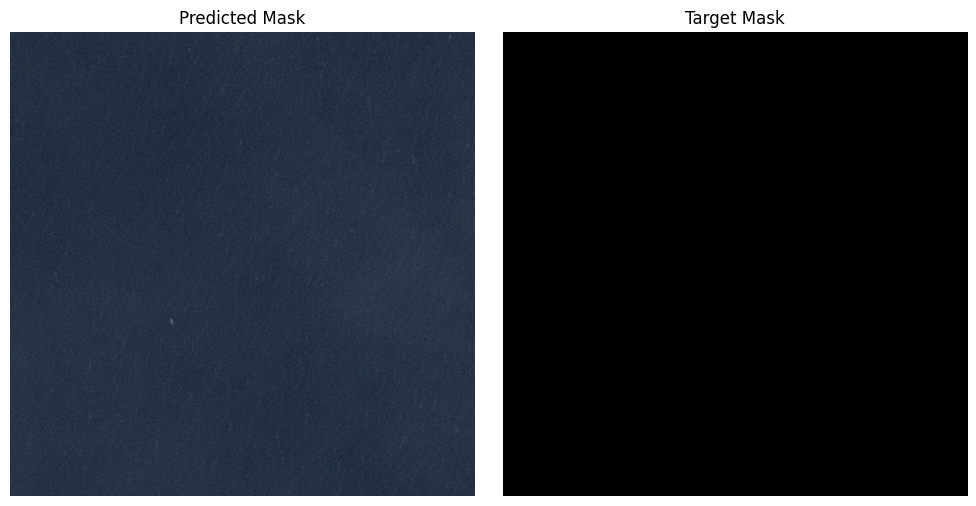

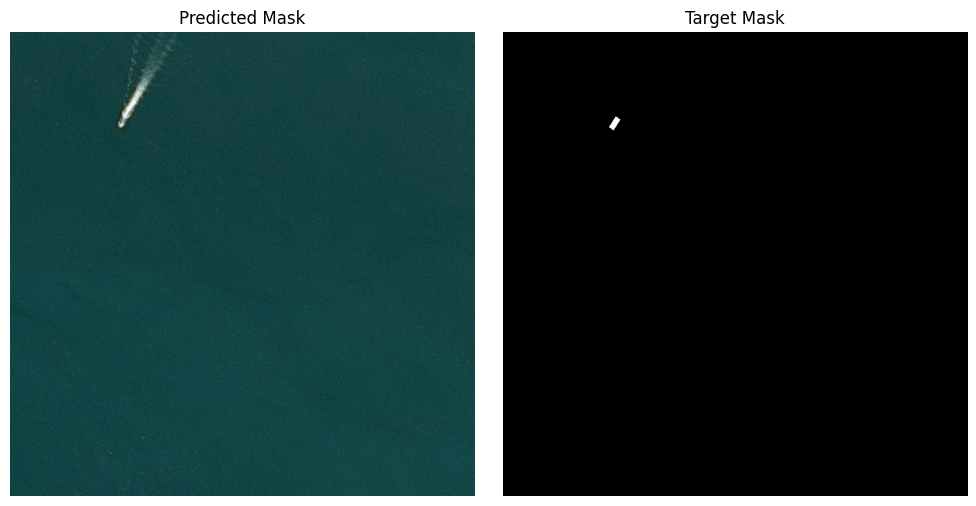

In [6]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from PIL import Image



# def decodeRle(rleMask):
#     rleMask = rleMask.split()
#     starts, lengths = [np.asarray(x, dtype=int) for x in (rleMask[0:][::2], rleMask[1:][::2])]
#     starts -= 1
#     ends = starts + lengths
#     img = np.zeros(768*768, dtype=np.uint8)
#     for lo, hi in zip(starts, ends):
#         img[lo:hi] = 1
#     return img.reshape(768,768).T


# def generateMaskImage(masksList):
#     maskImage = np.zeros(shape=(768,768))
#     for mask in masksList:
#         decodedMask = decodeRle(mask)
#         maskImage+=decodedMask
#     return maskImage

# for file in filenames:
#     img_path = "/kaggle/input/airbus-ship-detection/train_v2/"+file
    
#     pred_mask = np.array(Image.open(img_path))
#     target_mask = generateMaskImage(trainCsv.loc[trainCsv["ImageId"]==file]["EncodedPixels"])
    
#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 2, 1)
#     plt.imshow(pred_mask, cmap='gray')
#     plt.title('Predicted Mask')
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.imshow(target_mask, cmap='gray')
#     plt.title('Target Mask')
#     plt.axis('off')

#     plt.tight_layout()
#     plt.show()
    

In [ ]:
## training csv file read
masks = pd.read_csv("/kaggle/input/airbus-ship-detection/sample_submission_v2.csv")
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

In [ ]:
## distribution of ship images having different number of ships and data balancing
trainCsv = pd.read_csv("/kaggle/input/airbus-ship-detection/sample_submission_v2.csv")
shipsCsv = trainCsv
shipCsv = shipsCsv.dropna()
shipsCount = shipCsv.groupby(['ImageId'], sort=True).size().reset_index(name='Count')
print("Total images having ships :", len(shipsCount))
print("\nNumber of Images having different number of ships\n")
shipsCount["Count"].hist(bins=shipsCount['Count'].max())
shipsCount.sort_values("Count", axis = 0, ascending = False, inplace = True, na_position ='last') 



In [ ]:
## dataset generation after balancing
def generateDataSet():
    trainImages = []
    testImages = []
    maxShipsCount = 15
    for i in range(1, maxShipsCount+1):
        n = shipsCount["Count"].loc[shipsCount["Count"]==i].count()
        print(i,n)
        trainCount = int(90*n/100)
        images = list(shipsCount["ImageId"].loc[shipsCount["Count"]==i])

        for imageName in images[:trainCount]:
            trainImages.append(imageName)
        for imageName in images[trainCount:]:
            testImages.append(imageName) 
            
    return trainImages, testImages

## adding images having no ships
def addNoShipImages(trainImages, testImages):
    noShipsCsv =trainCsv[trainCsv['EncodedPixels'].isnull()]
    noShipsImages = noShipsCsv.ImageId.tolist()
    trainImages = trainImages + noShipsImages[:2000]
    testImages = testImages + noShipsImages[2000:2200]
    return trainImages, testImages

In [ ]:
trainImages, testImages = generateDataSet()
trainImages, testImages = addNoShipImages(trainImages, testImages)

In [ ]:
print(len(trainImages), len(testImages))

In [ ]:
## RAM memory issue thats why batch generator used,  keras_fir geneartor does data augmentation as well, loads data in batches
          
def imageGenerator(images, batchSize = 1):
    samples = []
    masks = []
    count = 0
    for i, imageName in enumerate(images):
        print
        image = cv2.imread(testImagesPath + imageName)
        masksList = trainCsv.loc[trainCsv["ImageId"]==imageName]["EncodedPixels"]
        maskImage = generateMaskImage(masksList)
        maskImage = maskImage.reshape(768,768,1)
        samples.append(image)
        masks.append(maskImage)
        
        count+=1
        if(count%batchSize==0):
#             print("batch", count)
            yield np.array(samples), np.array(masks)
            samples = []
            masks = []


In [ ]:
## train data generator
trainGenerator = imageGenerator(trainImages[:200], batchSize=4)
trainSamples, trainMasks = next(trainGenerator)
## test data generator
testGenerator = imageGenerator(trainImages[:20], batchSize=20)
testSamples, testMasks = next(testGenerator)
print(trainSamples.shape, trainMasks.shape)
print(testSamples.shape, testMasks.shape)


In [ ]:
### images raw pixels and mask generator for batch training, yields a batch sized training samples and masks at a time
sampleGenerator = ImageDataGenerator(rotation_range=20,
    zoom_range=0.25,
    shear_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.25)

maskGenerator = ImageDataGenerator(rotation_range=20,
    zoom_range=0.25,
    shear_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.25)
            
def augmentData(generator):
    for samples, masks in generator:
        augSamples = sampleGenerator.flow(255*samples, 
                             batch_size = samples.shape[0], 
                             seed = np.random.choice(range(10000)), 
                             shuffle=True)
        augMasks = maskGenerator.flow(masks, 
                             batch_size = samples.shape[0], 
                             seed = np.random.choice(range(10000)), 
                             shuffle=True)

        yield next(augSamples)/255.0, next(augMasks)

In [ ]:
## evaluation metric for model: Intersection over union
def IoU(trueMask, predMask):
    if np.max(trueMask) == 0.0:
        return IoU(1-trueMask, 1-predMask)
    intersect = np.sum(trueMask * predMask)
    union = np.sum(trueMask) + np.sum(predMask) - intersect
    return -np.mean( (intersect) / (union), axis=0)

In [ ]:
## UNET model architecture defined; loaded; compiled; loss and evaluation metric defined
model = unetModel(input_shape=trainSamples.shape[1:])
model.summary()
model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=binary_crossentropy, metrics=['binary_accuracy',  IoU])

In [ ]:
##Adveat's Section

filenames = ["0005d01c8.jpg", "00140e597.jpg","00113a75c.jpg","001dd855d.jpg","00269a792.jpg","001f3caca.jpg","0041d7084.jpg","002943412.jpg","002abd5df.jpg","002e85393.jpg"]
iou_threshold = 0.8

trainCsv = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv", index_col=0).dropna()
trainCsv = trainCsv.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()

class CheckOutputAndAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, interval=20, patience=5):
        super().__init__()
        self.all_target_images = [Image.open(f"/kaggle/input/airbus-ship-detection/train_v2/{file}") for file in filenames]
        self.all_target_masks = [generateMaskImage(trainCsv.loc[trainCsv["ImageId"]==file]["EncodedPixels"]) for file in filenames]
        self.all_target_instances = [extract_instances(mask) for mask in self.all_target_masks]
        self.interval = interval
        self.patience = patience
        self.wait = 0
        self.best_average_precision = -np.Inf
        self.best_epoch = 0
        self.predictions = None
    
    def extract_instances(self, mask):
        labeled_mask = np.zeros_like(mask, dtype=int)
        label = 1
        instances = []
        height, width = mask.shape

        for y in range(height):
            for x in range(width):
                if mask[y, x] == 1 and labeled_mask[y, x] == 0:
                    component = []
                    stack = [(y, x)]

                    while stack:
                        cy, cx = stack.pop()
                        if labeled_mask[cy, cx] == 0:
                            labeled_mask[cy, cx] = label
                            component.append((cy, cx))
                            for dy, dx in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                                ny, nx = cy + dy, cx + dx
                                if 0 <= ny < height and 0 <= nx < width and mask[ny, nx] == 1 and labeled_mask[ny, nx] == 0:
                                    stack.append((ny, nx))

                    instance_mask = np.zeros_like(mask)
                    for (iy, ix) in component:
                        instance_mask[iy, ix] = 1
                    instances.append(instance_mask)
                    label += 1

        return instances
    
    def compute_iou(self, pred_mask, target_mask):
        intersection = np.logical_and(target_mask, pred_mask).sum()
        union = np.logical_or(target_mask, pred_mask).sum()
        iou = intersection / union if union != 0 else 0
        return iou
    
    def compute_metrics(self, pred_masks):
        all_metrics = []

        for iter in range(len(self.all_target_images)):
            pred_instances = [instance for instance in self.extract_instances(pred_masks[iter])]
            target_instances = self.all_target_instances[iter]

            all_ious = []
            all_precisions = []
            all_recalls = []
            all_f1_scores = []
            all_average_precisions = []

            for target_mask in target_instances:
                best_iou = 0
                argmax_best_iou = -1

                for pred_mask in pred_instances:
                    iou = self.compute_iou(pred_mask, target_mask)
                    if iou > best_iou:
                        best_iou = iou
                        argmax_best_iou = pred_mask

                tp = best_iou >= iou_threshold
                fp = best_iou < iou_threshold and best_iou > 0
                fn = target_mask.sum() > 0 and best_iou == 0


                if tp:
                    precision, recall, f1, _ = 1.0, 1.0, 1.0, None
                else:
                    precision, recall, f1, _ = 0.0, 0.0, 0.0, None

                target_mask_flat = target_mask.flatten()
                best_pred_mask_flat = argmax_best_iou.flatten() if best_iou > 0 else np.zeros_like(target_mask_flat)
                average_precision = average_precision_score(target_mask_flat, best_pred_mask_flat)

                all_ious.append(best_iou)
                all_precisions.append(precision)
                all_recalls.append(recall)
                all_f1_scores.append(f1)
                all_average_precisions.append(average_precision)

            metrics = {
                'Precision': np.mean(all_precisions),
                'Recall': np.mean(all_recalls),
                'Dice Score': np.mean(all_f1_scores),
                'Average Precision': np.mean(all_average_precisions),
                'Jaccard': np.mean(all_ious)
            }
            
            all_metrics.append(metrics)

        average_metrics = {}
        num_metrics = len(all_metrics)
        for d in all_metrics:
            for key in d:
                if key in average_metrics:
                    average_metrics[key] += d[key]
                else:
                    average_metrics[key] = d[key]

        for key in average_metrics:
            average_metrics[key] /= num_metrics

        return average_metrics
    
    def show_masks(self, pred_mask, target_mask):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(target_mask, cmap='gray')
        plt.title('Target Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            predictions = self.model.predict(self.all_target_images)
            metrics = self.compute_metrics(predictions)
            
            # Display metrics
            print(f"\nMetrics at epoch {epoch + 1}:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")
            
            # Show masks for a sample image
            print(predictions.shape[0])
            for sample_index in range(predictions.shape[0]):  
                pred_mask = predictions[sample_index]
                target_mask = self.all_target_masks[sample_index]
                self.show_masks(pred_mask, target_mask)
            
            # Early stopping based on average precision
            current_avg_precision = metrics['Average Precision']
            if current_avg_precision > self.best_average_precision:
                self.best_average_precision = current_avg_precision
                self.best_epoch = epoch + 1
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nEarly stopping at epoch {epoch + 1} due to no improvement in Average Precision.")
                    self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        print(f"\nBest Average Precision of {self.best_average_precision:.4f} at epoch {self.best_epoch}.")

In [ ]:
check_output_accuracy_callback = CheckOutputAndAccuracy()

In [ ]:
### model training in batches, batch size = 4, data augmentation; run again for less number of epochs and steps to get output
history = model.fit_generator(augmentData(imageGenerator(trainImages)), 
                             steps_per_epoch=100, 
                             epochs=10, 
                             validation_data=(testSamples, testMasks),
                             callbacks=[check_output_accuracy_callback])

In [ ]:
print(history.history)

In [ ]:
plot_segm_history(
    history,
    metrics=['binary_accuracy',  'val_binary_accuracy', 'IoU','val_IoU'],
    losses=['loss', 'val_loss']) 

In [ ]:
### load and save model
from keras.models import load_model
from keras.models import model_from_json
model_json = fullres_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
fullres_model.save_weights("model.h5")


json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


In [ ]:
def getBBoxFromMask(maskImage):
    labels = label(maskImage) 
    coordinates = regionprops(labels)
    return coordinates

In [ ]:
import os
import numpy as np
from skimage.measure import label, regionprops

count = 0
testImagesPath = "C:/Users\K\Desktop\ZAKI  FOLDER\mtech\sml\project\code\ships_small_dataset/test/"
for dir, _, files in os.walk(testImagesPath):
    for file in files[10:20]:
        path = os.path.join(testImagesPath, file)
        image = cv2.imread(path)
        plt.figure()
        plt.title('original image')
        plt.imshow(image)
        image = cv2.resize(image, (256, 256))
        image = np.expand_dims(image, 0)/255.0
        predictedMask = loaded_model.predict(image)
        plt.figure()
        plt.imshow(predictedMask[0,:,:, 0])
        plt.title('predicted mask')
        coords = getBBoxFromMask(predictedMask[0,:,:, 0])
        image = cv2.imread(path)
        image = cv2.resize(image, (256, 256))
        for coord in coords:
            cv2.rectangle(image, (coord.bbox[1], coord.bbox[0]), (coord.bbox[3], coord.bbox[2]), (255, 0, 0), 2)
        plt.figure()
        plt.title('detected bounding boxes image')
        plt.imshow(image)        


In [ ]:
import warnings
warnings.filterwarnings('ignore')